In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras
import numpy as np

from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,add
from keras.models import Model
from keras.optimizers import RMSprop
import cv2
from PIL import Image
from keras import Sequential,backend
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input,Convolution2D,MaxPooling2D
from keras.layers.core import Dense,Dropout,Activation,Flatten,Lambda
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
import numpy as np
import os, time
#from scipy.misc import imresize
import itertools
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
import os

Using TensorFlow backend.
W0706 07:35:13.616220 140454837479296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0706 07:35:13.617631 140454837479296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0706 07:35:13.620868 140454837479296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0706 07:35:13.812382 140454837479296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [3]:
import cv2
from PIL import Image
from tqdm import tqdm, trange
images = []
pre_images = []
for i in trange(0, 1000):
  img = Image.open('drive/My Drive/4000images/' + str(i + 1) + '.png')
  img = np.array(img)
  images.append(img)

100%|██████████| 1000/1000 [04:04<00:00,  3.81it/s]


In [0]:
import numpy as np
import pywt
arr1, arr2, arr3, arr4 = [], [], [], []
for image in images:
  r = np.array(image)[:,:,0]
  g = np.array(image)[:,:,1]
  b = np.array(image)[:,:,2]
  rec1 = np.ones((128, 128, 3))
  rec2 = np.ones((128, 128, 3))
  rec3 = np.ones((128, 128, 3))
  rec4 = np.ones((128, 128, 3))
  rcoeffs = pywt.dwt2(r,'haar')
  LL, (LH, HL, HH) = rcoeffs
  rec1[:,:,0] = LL
  rec2[:,:,0] = LH
  rec3[:,:,0] = HL
  rec4[:,:,0] = HH
  gcoeffs = pywt.dwt2(g,'haar')
  LL, (LH, HL, HH) = gcoeffs
  rec1[:,:,1] = LL
  rec2[:,:,1] = LH
  rec3[:,:,1] = HL
  rec4[:,:,1] = HH
  bcoeffs = pywt.dwt2(b,'haar')
  LL, (LH, HL, HH) = bcoeffs
  rec1[:,:,2] = LL
  rec2[:,:,2] = LH
  rec3[:,:,2] = HL
  rec4[:,:,2] = HH
  rec1 = rec1.astype(int)
  rec2 = rec2.astype(int)
  rec3 = rec3.astype(int)
  rec4 = rec4.astype(int)
  arr1.append(rec1)
  arr2.append(rec2)
  arr3.append(rec3)
  arr4.append(rec4)

N = 1000
arr1 = np.array(arr1)
arr1 = arr1.reshape((N,128,128,3))
arr2 = np.array(arr2)
arr2 = arr2.reshape((N,128,128,3))
arr3 = np.array(arr3)
arr3 = arr3.reshape((N,128,128,3))
arr4 = np.array(arr4)
arr4 = arr4.reshape((N,128,128,3))
split = 900
x_test1 = arr1[split:]
x_train1 = arr1[:split]
x_test2 = arr2[split:]
x_train2 = arr2[:split]
x_test3 = arr3[split:]
x_train3 = arr3[:split]
x_test4 = arr4[split:]
x_train4 = arr4[:split]

x_train1 = x_train1.astype('float32') / np.amax(arr1)
x_test1 = x_test1.astype('float32') / np.amax(arr1)

x_train2 = x_train2.astype('float32') / np.amax(arr2)
x_test2 = x_test2.astype('float32') / np.amax(arr2)

x_train3 = x_train3.astype('float32') / np.amax(arr3)
x_test3 = x_test3.astype('float32') / np.amax(arr3)

x_train4 = x_train4.astype('float32') / np.amax(arr4)
x_test4 = x_test4.astype('float32') / np.amax(arr4)

In [0]:
from skimage.measure import compare_ssim as ssim
def residualloss(a):
    def loss(y_true, y_pred):
        return K.mean(K.square(y_pred - (a - y_true)), axis=-1)
    return loss

def bicub(x):
  x = x * 255.0
  fi = tf.image.resize_bicubic(x,[128,128])
  fi = tf.dtypes.cast(fi,dtype=tf.float32)
  fi = fi/255.0
  return fi
def SSIM(y_true, y_pred):
  return ssim(y_true, y_pred, multichannel=True)

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import numpy as np


MAX = 1
GAUS_KERNEL = 3
GAUS_SIGMA  = 1.2

def Gaussian_Filter(kernel_size=GAUS_KERNEL, sigma=GAUS_SIGMA):
    
	k = (kernel_size-1)//2 
	filter = []
	sigma_2 = sigma**2
	for i in range(kernel_size):
		filter_row = []
		for j in range(kernel_size):
			Hij = np.exp(-((i+1-(k+1))**2 + (j+1-(k+1))**2)/(2*sigma_2))/(2*np.pi*sigma_2)
			filter_row.append(Hij)
		filter.append(filter_row)
	
	return np.asarray(filter).reshape(kernel_size,kernel_size,1,1)

gaussian_filter = tf.constant(Gaussian_Filter(), tf.float32) 				
h_filter = tf.reshape(tf.constant([[-1,0,1],[-2,0,2],[-1,0,1]], tf.float32), [3,3,1,1])	
v_filter = tf.reshape(tf.constant([[1,2,1],[0,0,0],[-1,-2,-1]], tf.float32), [3,3,1,1])	

np_filter_0 = np.zeros((3,3,1,2))
np_filter_0[1,0,0,0], np_filter_0[1,2,0,1] = 1,1 
filter_0 = tf.constant(np_filter_0, tf.float32)
np_filter_90 = np.zeros((3,3,1,2))
np_filter_90[0,1,0,0], np_filter_90[2,1,0,1] = 1,1 
filter_90 = tf.constant(np_filter_90, tf.float32)
np_filter_45 = np.zeros((3,3,1,2))
np_filter_45[0,2,0,0], np_filter_45[2,0,0,1] = 1,1 
filter_45 = tf.constant(np_filter_45, tf.float32)
np_filter_135 = np.zeros((3,3,1,2))
np_filter_135[0,0,0,0], np_filter_135[2,2,0,1] = 1,1 
filter_135 = tf.constant(np_filter_135, tf.float32)
	
np_filter_sure = np.ones([3,3,1,1]); np_filter_sure[1,1,0,0] = 0
filter_sure = tf.constant(np_filter_sure, tf.float32)
border_paddings = tf.constant([[0,0],[1,1],[1,1],[0,0]])

def Border_Padding(x, pad_width):
	for _ in range(pad_width): x = tf.pad(x, border_paddings, 'SYMMETRIC')
	return x

def FourAngles(d):
	d0   = tf.to_float(tf.greater_equal(d,157.5))+tf.to_float(tf.less(d,22.5))
	d45  = tf.to_float(tf.greater_equal(d,22.5))*tf.to_float(tf.less(d,67.5))
	d90  = tf.to_float(tf.greater_equal(d,67.5))*tf.to_float(tf.less(d,112.5))
	d135 = tf.to_float(tf.greater_equal(d,112.5))*tf.to_float(tf.less(d,157.5))
	return (d0,d45,d90,d135)


def TF_Canny(img_tensor, minRate=0.10, maxRate=0.40,preserve_size=True, remove_high_val=False, return_raw_edges=False):
	img_tensor = (img_tensor)*MAX
	if preserve_size: img_tensor = Border_Padding(img_tensor, (GAUS_KERNEL-1)//2)

	x_gaussian = tf.nn.convolution(img_tensor, gaussian_filter, padding='VALID')
	if remove_high_val: x_gaussian = tf.clip_by_value(x_gaussian, 0, MAX/2)
	

	if preserve_size: x_gaussian = Border_Padding(x_gaussian, 1)
	Gx = tf.nn.convolution(x_gaussian, h_filter, padding='VALID')
	Gy = tf.nn.convolution(x_gaussian, v_filter, padding='VALID')
	G 		= tf.sqrt(tf.square(Gx) + tf.square(Gy))
	BIG_PHI = tf.atan2(Gy,Gx)
	BIG_PHI	= (BIG_PHI*180/np.pi)%180 		
	D_0,D_45,D_90,D_135 = FourAngles(BIG_PHI)	
	
	
	targetPixels_0 = tf.nn.convolution(G, filter_0, padding='SAME')
	isGreater_0 = tf.to_float(tf.greater(G*D_0, targetPixels_0))
	isMax_0 = isGreater_0[:,:,:,0:1]*isGreater_0[:,:,:,1:2]

	targetPixels_90 = tf.nn.convolution(G, filter_90, padding='SAME')
	isGreater_90 = tf.to_float(tf.greater(G*D_90, targetPixels_90))
	isMax_90 = isGreater_90[:,:,:,0:1]*isGreater_90[:,:,:,1:2]
	
	targetPixels_45 = tf.nn.convolution(G, filter_45, padding='SAME')
	isGreater_45 = tf.to_float(tf.greater(G*D_45, targetPixels_45))
	isMax_45 = isGreater_45[:,:,:,0:1]*isGreater_45[:,:,:,1:2]
	
	targetPixels_135 = tf.nn.convolution(G, filter_135, padding='SAME')
	isGreater_135 = tf.to_float(tf.greater(G*D_135, targetPixels_135))
	isMax_135 = isGreater_135[:,:,:,0:1]*isGreater_135[:,:,:,1:2]

	edges_raw = G*(isMax_0 + isMax_90 + isMax_45 + isMax_135)
	edges_raw = tf.clip_by_value(edges_raw, 0, MAX)
  
	if return_raw_edges: return tf.squeeze(edges_raw)
	
	edges_sure = tf.to_float(tf.greater_equal(edges_raw, maxRate))
	edges_weak = tf.to_float(tf.less(edges_raw, maxRate))*tf.to_float(tf.greater_equal(edges_raw, minRate))
	
	edges_connected = tf.nn.convolution(edges_sure, filter_sure, padding='SAME')*edges_weak
	for _ in range(10): edges_connected = tf.nn.convolution(edges_connected, filter_sure, padding='SAME')*edges_weak
	
	edges_final = edges_sure + tf.clip_by_value(edges_connected,0,MAX)
	return tf.squeeze(edges_final)

def edge_loss(y_true, y_pred):
    y_true = tf.cast(y_true,dtype = tf.float32)
    y_pred = tf.cast(y_pred,dtype = tf.float32)
    E = TF_Canny(y_true, return_raw_edges=False)
    E = 1 - E
    E = tf.cast(E,dtype = tf.float32)
    A = y_true - y_pred
    A = tf.cast(A,dtype = tf.float32)
    E = tf.reshape(E,(9,128,128,3))
    LP = K.abs(A)
    LP = tf.cast(LP,dtype = tf.float32)
    SQ = K.mean(K.square(y_pred - y_true), axis=-1)
    
    LE = tf.multiply(E,LP)
    LE = tf.cast(LE,dtype = tf.float32)
    
    SQ1 = K.mean(K.square(LE), axis=-1)
    
    los = 0.7 * SQ + 0.3 * SQ1
    return los


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, subtract
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense,Dropout,Activation,Flatten,Lambda

input_img = Input(shape=(128,128,3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), strides = (2, 2), activation='relu', padding='same')(x)
#x = Conv2D(64, (3, 3), strides = (2, 2), activation='relu', padding='same')(x)



#mapp=Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
#sal=Conv2D(64, (3, 3), activation='linear', padding='same', name='sal')(mapp)
#saliency=Model(input_img, sal)
#saliency.summary()


encoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

inp = Lambda(bicub)(encoded)
dup = inp

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inp)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
res_img = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(model)
output_img = add([dup, res_img])
# output_img = Activation('sigmoid')(output_img)

model = Model(input_img, res_img)

# b = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(optimizer= b, loss=residualmse,metrics=[SSIM, M_SSIM ,negSSIM, "accuracy"])


model.compile(optimizer= 'adam', loss='mean_absolute_error')


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
sal (Conv2D)                 (None, 32, 32, 64)        36928     
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


W0618 09:36:22.601227 140622465574784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 3)         1731      
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
__________

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, subtract, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense,Dropout,Activation,Flatten,Lambda

input_img = Input(shape=(128,128,3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = Conv2D(3, (3,3), strides = (2, 2), activation='sigmoid', padding='same')(x)

x = Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same')(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
output_img = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
# output_img = Activation('sigmoid')(output_img)

res_img = output_img
model1 = Model(input_img, res_img)

# b = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(optimizer= b, loss=residualmse,metrics=[SSIM, M_SSIM ,negSSIM, "accuracy"])


model1.compile(optimizer= 'adam', loss='mean_absolute_error')


model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 3)         435       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 16)      784       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 16)      2320      
__________

In [0]:
only_decoder = Model(model.layers[4].input, model.layers[8].output)
Y = only_decoder.predict(X)

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:180: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer conv2d_3.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: conv2d_3/Sigmoid:0
  str(x.name))


ValueError: ignored

In [0]:
no_of_epochs = 400

In [0]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

In [0]:
# import shutil

# shutil.rmtree('drive/My Drive/weights2')
import os
if not os.path.exists('drive/My Drive/altweights1'):
    os.makedirs('drive/My Drive/altweights1')

In [0]:
mc = keras.callbacks.ModelCheckpoint('drive/My Drive/altweights1/weights{epoch}.hdf5', save_best_only=False, period=1,verbose = 1)
tbc = TensorBoardColab()
model.fit(x_train1, x_train1,
                epochs=no_of_epochs,
                batch_size=8,
                shuffle=True,
                callbacks=[mc,TensorBoardColabCallback(tbc)])

Wait for 8 seconds...
TensorBoard link:
https://b2bef6bd.ngrok.io


W0618 09:37:07.425612 140622465574784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0618 09:37:08.149678 140622465574784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/400
900/900 [==============================] - 43s 48ms/step - loss: 0.1835

Epoch 00001: saving model to drive/My Drive/altweights1/weights1.hdf5
Epoch 2/400
900/900 [==============================] - 40s 44ms/step - loss: 0.0888

Epoch 00002: saving model to drive/My Drive/altweights1/weights2.hdf5
Epoch 3/400
900/900 [==============================] - 40s 44ms/step - loss: 0.0863

Epoch 00003: saving model to drive/My Drive/altweights1/weights3.hdf5
Epoch 4/400
900/900 [==============================] - 40s 44ms/step - loss: 0.0760

Epoch 00004: saving model to drive/My Drive/altweights1/weights4.hdf5
Epoch 5/400
900/900 [==============================] - 40s 45ms/step - loss: 0.0783

Epoch 00005: saving model to drive/My Drive/altweights1/weights5.hdf5
Epoch 6/400
900/900 [==============================] - 39s 44ms/step - loss: 0.0777

Epoch 00006: saving model to drive/My Drive/altweights1/weights6.hdf5
Epoch 7/400
900/900 [==============================] - 40s 44ms/step -

In [0]:
model.load_weights('drive/My Drive/altweights1/weights389.hdf5')
ans1 = model.predict(x_test1)

In [0]:
NN = 0
for i in range(100):
  NN += ssim(ans1[i], x_test1[i], multichannel=True)
print(NN/100.)

0.9573501259308114


W0613 19:45:38.586735 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


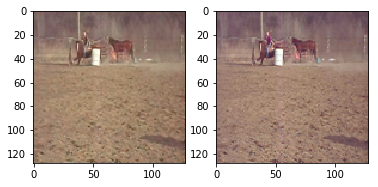

W0613 19:45:39.127791 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


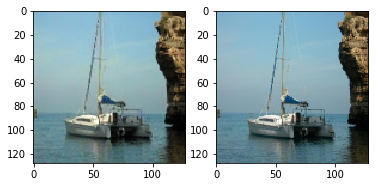

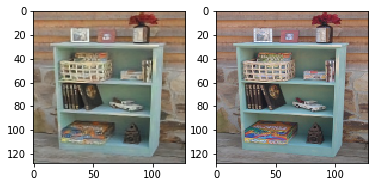

W0613 19:45:39.692248 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


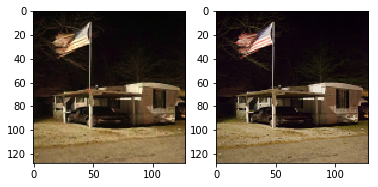

W0613 19:45:39.972585 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


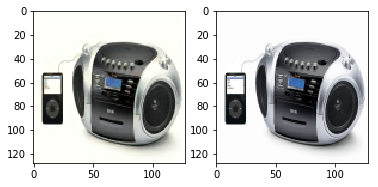

W0613 19:45:40.228827 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


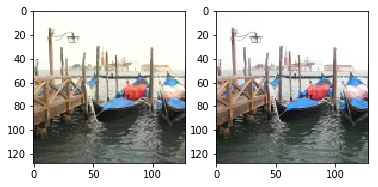

W0613 19:45:40.488251 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


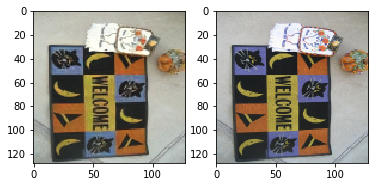

W0613 19:45:40.820215 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


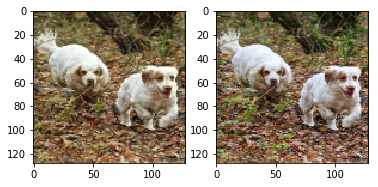

W0613 19:45:41.095487 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


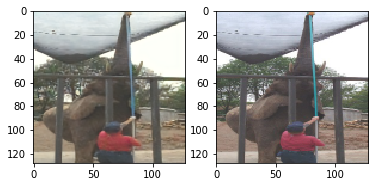

W0613 19:45:41.368738 140298785404800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


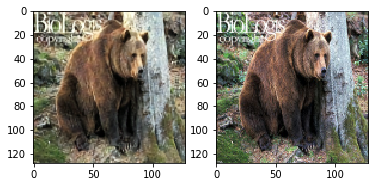

In [0]:
for i in range(10):
  plt.subplot(1, 2, 1)
  plt.imshow(ans1[i])
  plt.subplot(1, 2, 2)
  plt.imshow(x_test1[i])
  plt.show()

In [0]:
# import shutil

# shutil.rmtree('drive/My Drive/weights2')
import os
if not os.path.exists('drive/My Drive/altweights1'):
    os.makedirs('drive/My Drive/altweights1')

In [0]:
mc = keras.callbacks.ModelCheckpoint('drive/My Drive/altweights1/weights{epoch}.hdf5', save_best_only=False, period=1,verbose = 1)
model.fit(x_train2, x_train2,
          validation_data = (x_train2, x_train2),
                epochs=100,
                batch_size=9,
                shuffle=True,
                callbacks=[mc])

Train on 900 samples, validate on 900 samples
Epoch 1/100
900/900 [==============================] - 24s 26ms/step - loss: 0.0250 - val_loss: 0.0187

Epoch 00001: saving model to drive/My Drive/altweights1/weights1.hdf5
Epoch 2/100
900/900 [==============================] - 22s 24ms/step - loss: 0.0172 - val_loss: 0.0176

Epoch 00002: saving model to drive/My Drive/altweights1/weights2.hdf5
Epoch 3/100
900/900 [==============================] - 22s 25ms/step - loss: 0.0153 - val_loss: 0.0149

Epoch 00003: saving model to drive/My Drive/altweights1/weights3.hdf5
Epoch 4/100
900/900 [==============================] - 22s 25ms/step - loss: 0.0144 - val_loss: 0.0138

Epoch 00004: saving model to drive/My Drive/altweights1/weights4.hdf5
Epoch 5/100
900/900 [==============================] - 23s 25ms/step - loss: 0.0138 - val_loss: 0.0141

Epoch 00005: saving model to drive/My Drive/altweights1/weights5.hdf5
Epoch 6/100
900/900 [==============================] - 23s 25ms/step - loss: 0.0135 

In [0]:
model.load_weights('drive/My Drive/altweights2/weights33.hdf5')
ans2 = model.predict(x_test2)

In [0]:
for i in range(100):
  plt.subplot(1, 2, 1)
  plt.imshow(ans2[i])
  plt.subplot(1, 2, 2)
  plt.imshow(x_test2[i])
  plt.show()

In [0]:
NN = 0
for i in range(100):
  NN += ssim(ans2[i], x_test2[i], multichannel=True)
print(NN/100.)

In [0]:
mc = keras.callbacks.ModelCheckpoint('drive/My Drive/weights3/weights{epoch}.hdf5', save_best_only=False, period=1,verbose = 1)
model.fit(x_train3, x_train3,
                epochs=100,
                batch_size=8,
                shuffle=True,
                callbacks=[mc])

In [0]:
model.load_weights('drive/My Drive/weights3/weights99.hdf5')
ans3 = model.predict(x_test3)

In [0]:
NN = 0
for i in range(100):
  NN += ssim(ans3[i], x_test3[i], multichannel=True)
print(NN/100.)

In [0]:
mc = keras.callbacks.ModelCheckpoint('drive/My Drive/weights4/weights{epoch}.hdf5', save_best_only=False, period=1,verbose = 1)
model.fit(x_train4, x_train4,
                epochs=25,
                batch_size=8,
                shuffle=True,
                callbacks=[mc])

In [0]:
model.load_weights('drive/My Drive/weights4/weights24.hdf5')
ans4 = model.predict(x_test4)

In [0]:
NN = 0
for i in range(100):
  NN += ssim(ans4[i], x_test4[i], multichannel=True)
print(NN/100.)

In [0]:
def compute(index):
  timage = images[900 + index]
  f1 = ans1[index] * np.amax(arr1)
  f2 = ans2[index] * np.amax(arr2)
  f3 = ans3[index] * np.amax(arr3)
  f4 = ans4[index] * np.amax(arr4)
  rec_image = np.ones((256, 256, 3), dtype=int)
  
  rcoeffs = f1[:,:,0], (f2[:,:,0], f3[:,:,0], f4[:,:,0])
  rec_image[:,:,0] = pywt.idwt2(rcoeffs, 'haar')
  
  gcoeffs = f1[:,:,1], (f2[:,:,1], f3[:,:,1], f4[:,:,1])
  rec_image[:,:,1] = pywt.idwt2(gcoeffs, 'haar')
  
  bcoeffs = f1[:,:,2], (f2[:,:,2], f3[:,:,2], f4[:,:,2])
  rec_image[:,:,2] = pywt.idwt2(bcoeffs, 'haar')
  return rec_image

In [0]:
for i in range(100):
  plt.subplot(1,2,1)
  plt.imshow(compute(i))
  plt.subplot(1,2,2)
  plt.imshow(images[900 + i])
  plt.show()

In [0]:
from skimage.measure import compare_ssim as ssim
NN = 0
for i in range(100):
  final_image = compute(i)
  NN += ssim(images[900 + i], final_image, multichannel=True)
print(NN/100.)

In [0]:
from skimage.measure import compare_psnr as psnr
NN = 0
for i in range(100):
  final_image = compute(i)
  NN += psnr(images[900 + i], final_image, data_range=None)
print(NN/100.)